# **Check enviroment**

Set data_path to make notebooks works well both on local and google drive.

In [1]:
import sys
import os
data_path = ''
# Check if the environment is Google Colab
if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install tensorflow -q
    !pip install keras -q
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install matplotlib -q
    !pip install umap-learn -q
    !pip install lightgbm
    !pip install xgboost

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your own google drive. 
    data_path = '/content/drive/MyDrive/Heartbeat_Project/'
    
else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/raw/'

Path = dict({
    'ptbdb_normal': data_path +  'ptbdb_normal.csv',
    'ptbdb_abnormal':  data_path + 'ptbdb_abnormal.csv',
})

Running on local environment
Current working directory: g:\Meine Ablage\heartbeat-analysis-ai\notebooks


# **Import packages:**

In [2]:
# Verify installation and import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import umap

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.manifold import TSNE, Isomap
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline



In [3]:
def addColumnsToDataframe(df):
    """
    As the dataset is composed with 188 columns with the 188th columns as the category values,
    so we give the last column the name 'target', others named with 'c_182'
    """
    num_columns= df.shape[1]
    feature_col_name = ['c_' + str(i) for i in range(0, num_columns - 1)]
    df_columns = feature_col_name + ['target']
    df.columns = df_columns
    return df

def convertColumnAsInt(df, column):
    """
    As the category value is in float type. We want to get the int to identify the category.
    """
    df[column] = df[column].astype(int)
    return df

def getBarChartFromCategoryValueCounts(category_value_counts):
    """
    We call the plot over the pandas series object to plot the category count values
    """
    plt.figure(figsize=(10, 6))
    bar_chart = category_value_counts.plot(kind='bar')
    plt.xlabel('Categories')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(False)
    plt.xticks(rotation=360)
    for i in bar_chart.containers:
        bar_chart.bar_label(i, label_type='edge')
    plt.show()


def showTop10DataInChart(df):
    plt.figure(figsize=(10, 6))
    xDataAxis = list(range(0, df.shape[1]))
    yDataRows = list(df.values[1: 10])
    for y in yDataRows:
        plt.plot(xDataAxis, y)
    plt.show()

In [4]:
ptbdb_normal = pd.read_csv(Path.get('ptbdb_normal'), header=None ) 
ptbdb_normal_with_columns = addColumnsToDataframe(ptbdb_normal) # add columns to the dataframe
ptbdb_normal_with_columns = convertColumnAsInt(ptbdb_normal_with_columns, 'target') # convert the target column to int

In [5]:
ptbdb_abnormal = pd.read_csv(Path.get('ptbdb_abnormal'), header=None ) 
ptbdb_abnormal_with_columns = addColumnsToDataframe(ptbdb_abnormal) # add columns to the dataframe
ptbdb_abnormal_with_columns = convertColumnAsInt(ptbdb_abnormal_with_columns, 'target') # convert the target column to int

Merge normal and abnomal data to one dataset and shuffle it

In [6]:
#Merge the datasets
ptbdb = pd.concat([ptbdb_abnormal_with_columns, ptbdb_normal_with_columns], ignore_index=True) # ingore the index to make the index continuous
#Shuffle the dataset
ptbdb = ptbdb.sample(frac=1).reset_index(drop=True)

In [7]:
#Split the data into training (80%) and testing (20%)
from sklearn.model_selection import train_test_split
ptbdb_train, ptbdb_test = train_test_split(ptbdb, test_size=0.2, random_state=42)


Remove duplicates

In [8]:
# Remove duplicates from the training set
ptbdb_train = ptbdb_train.drop_duplicates()

# Remove duplicates from the testing set
ptbdb_test = ptbdb_test.drop_duplicates()

# Verify the removal by checking the number of duplicated rows again
nb_rows_duplicated_train = ptbdb_train.duplicated().sum()
print("Number of rows duplicated in train set after removal:", nb_rows_duplicated_train)

nb_rows_duplicated_test = ptbdb_test.duplicated().sum()
print("Number of rows duplicated in test set after removal:", nb_rows_duplicated_test)


Number of rows duplicated in train set after removal: 0
Number of rows duplicated in test set after removal: 0


In [9]:
# Define mapping dictionary
class_mapping = {
    1: 'Normal',
    0: 'Abnormal'
}

# Define custom colors for each category
color_mapping = {
    0: 'green',    # Normal beat
    1: 'red',      # Abnormal beat 
}

classes_to_plot = [0, 1]

# Calculate value counts based on mapped class names
value_counts_series_train = ptbdb_train['target'].map(class_mapping).value_counts()
# Calculate value counts based on mapped class names
value_counts_series_test = ptbdb_test['target'].map(class_mapping).value_counts()

# load and split cleaned data

In [10]:
# File paths
train_file_path = 'ptbdb_train_clean.csv'
test_file_path = 'ptbdb_test_clean.csv'

# If the cleaned data files do not exist, save them
if not os.path.isfile(train_file_path) or not os.path.isfile(test_file_path):
    # Read the data
    # Encode the labels
    ptbdb_train['target'] = ptbdb_train['target'].replace({'Normal': 1, 'Abnormal': 0})
    ptbdb_test['target'] = ptbdb_test['target'].replace({'Normal': 1, 'Abnormal': 0})

    # Save cleaned data
    ptbdb_train.to_csv(train_file_path, index=False)
    ptbdb_test.to_csv(test_file_path, index=False)
else:
    print("Cleaned data files already exist.")

# Read cleaned data
try:
    ptbdb_train = pd.read_csv(train_file_path, header=0)
    ptbdb_test = pd.read_csv(test_file_path, header=0)
except FileNotFoundError:
    print(f"Error: The file {train_file_path} or {test_file_path} does not exist.")
    # Optionally, add code to handle this case, e.g., exit or retry

# Show the distribution of the two classes
print('Class distribution in training\n', ptbdb_train['target'].value_counts(normalize=True))
print('\nClass distribution in test\n', ptbdb_test['target'].value_counts(normalize=True))
print('\n')



Cleaned data files already exist.
Class distribution in training
 target
1    0.720571
0    0.279429
Name: proportion, dtype: float64

Class distribution in test
 target
1    0.727148
0    0.272852
Name: proportion, dtype: float64




In [11]:
# Split the data into features (X) and target (y)
X_train = ptbdb_train.drop(columns=['target'])
y_train = ptbdb_train['target']

X_test = ptbdb_test.drop(columns=['target'])
y_test = ptbdb_test['target']

# Grid Search for best performing models on the  the PTBDB dataset 

Applied:
- Tree with SMOTE (best base model)
- Balanced Random Forest Classifier (just for testing)
- XGBoost with Oversampling (best ensamble model)
- XGBoost with Oversampling with scale_pos_weight Parameter instead of Oversampling


# Decision Tree with SMOTE

Decision Tree with SMOTE Best parameters: {'model__criterion': 'entropy', 'model__max_depth': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10}
Decision Tree with SMOTE Best score: 0.9422676480339364
Decision Tree with SMOTE F1 score: 0.9459783913565426


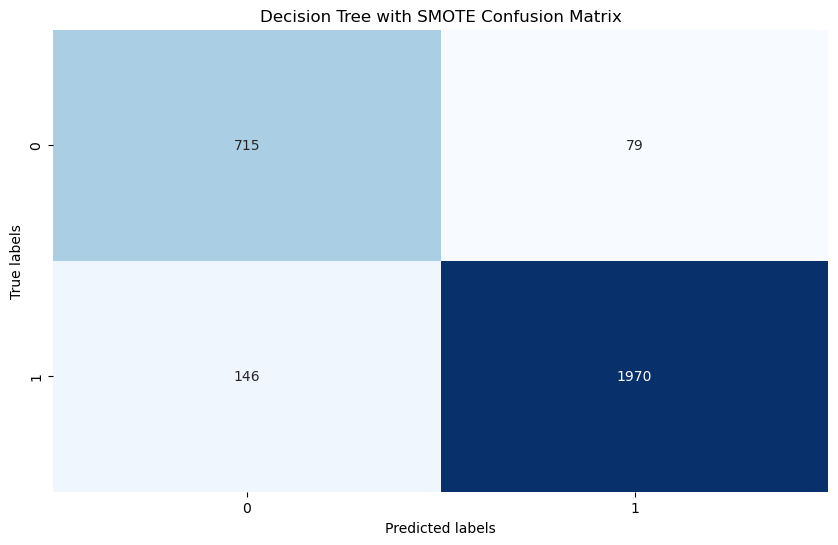

Decision Tree with SMOTE Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86       794
           1       0.96      0.93      0.95      2116

    accuracy                           0.92      2910
   macro avg       0.90      0.92      0.91      2910
weighted avg       0.93      0.92      0.92      2910



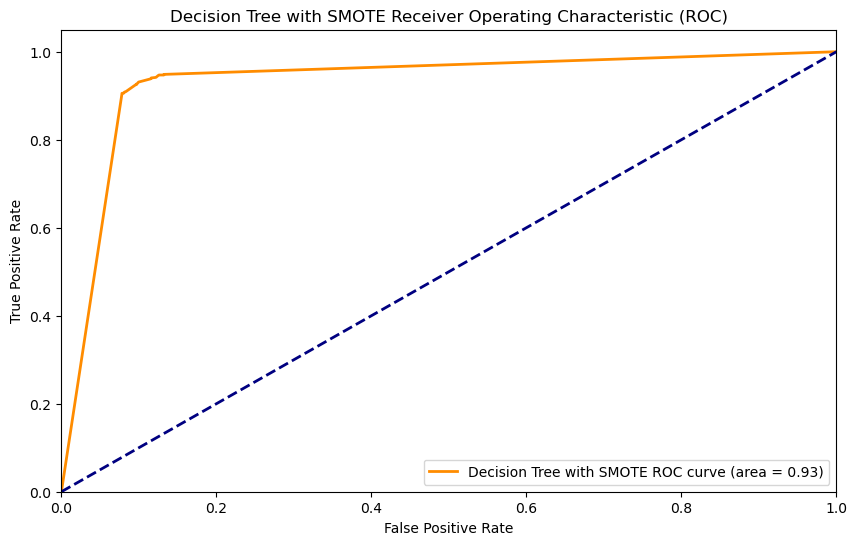

In [33]:
# Define the scaler and SMOTE
scaler = StandardScaler()
smote = SMOTE(random_state=42)

# Define Decision Tree model
tree_model = DecisionTreeClassifier(random_state=42)

# Grid parameters for Decision Tree
tree_grid_params = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Create a pipeline that includes scaling, SMOTE, and Decision Tree
pipeline = Pipeline([
    ('scaler', scaler),
    ('smote', smote),
    ('model', tree_model)
])

# Define GridSearchCV with the pipeline for Decision Tree
tree_grid_search = GridSearchCV(pipeline, tree_grid_params, cv=5, scoring='f1', n_jobs=-1)

try:
    # Fit the Decision Tree grid search on the training data
    tree_grid_search.fit(X_train, y_train)
    
    # Get the best parameters and model for Decision Tree
    tree_best_params = tree_grid_search.best_params_
    print("Decision Tree with SMOTE Best parameters:", tree_best_params)

    tree_best_score = tree_grid_search.best_score_
    print("Decision Tree with SMOTE Best score:", tree_best_score)

    tree_best_model = tree_grid_search.best_estimator_

    # Predict and evaluate Decision Tree on test data using the pipeline
    y_pred_tree = tree_best_model.predict(X_test)
    f1_tree = f1_score(y_test, y_pred_tree)
    print("Decision Tree with SMOTE F1 score:", f1_tree)

    # Generate and plot confusion matrix
    conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)
    plt.figure(figsize=(10, 6))
    sns.heatmap(conf_matrix_tree, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Decision Tree with SMOTE Confusion Matrix')
    plt.show()

    # Generate and print classification report
    class_report_tree = classification_report(y_test, y_pred_tree)
    print("Decision Tree with SMOTE Classification Report:\n", class_report_tree)

    # ROC curve and AUC for binary classification
    if len(np.unique(y_test)) == 2:  # Ensure binary classification
        y_prob_tree = tree_best_model.predict_proba(X_test)[:, 1]
        fpr_tree, tpr_tree, _ = roc_curve(y_test, y_prob_tree)
        roc_auc_tree = auc(fpr_tree, tpr_tree)

        plt.figure(figsize=(10, 6))
        plt.plot(fpr_tree, tpr_tree, color='darkorange', lw=2, label='Decision Tree with SMOTE ROC curve (area = %0.2f)' % roc_auc_tree)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Decision Tree with SMOTE Receiver Operating Characteristic (ROC)')
        plt.legend(loc='lower right')
        plt.show()
    else:
        print("ROC curve is only applicable for binary classification in Decision Tree.")
    
except ValueError as e:
    print(f"Error during GridSearchCV: {e}")

## Balanced Random Forest Classifier Grid Search

c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
33 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Isabell Gurstein\

Balanced RF Best parameters: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_split': 2, 'model__n_estimators': 100}
Balanced RF Best score: 0.9774187258548632
Balanced RF F1 score: 0.9847310312426591


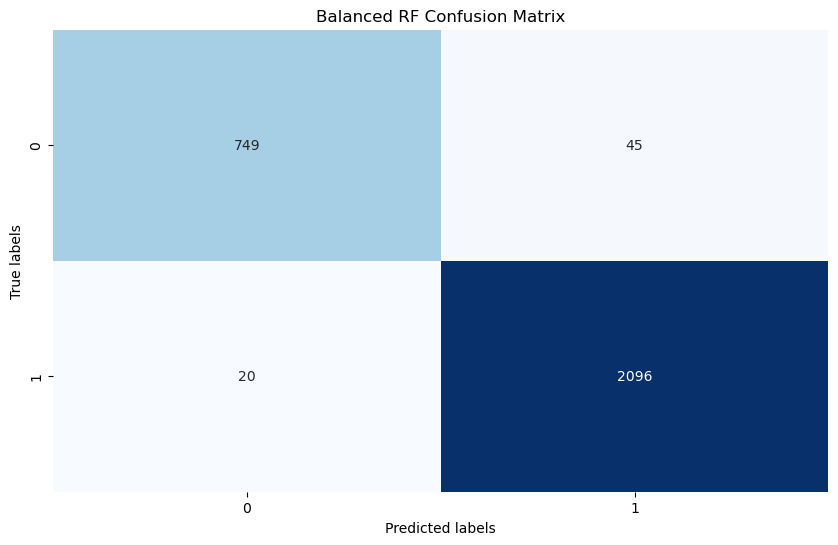

Balanced RF Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.96       794
           1       0.98      0.99      0.98      2116

    accuracy                           0.98      2910
   macro avg       0.98      0.97      0.97      2910
weighted avg       0.98      0.98      0.98      2910



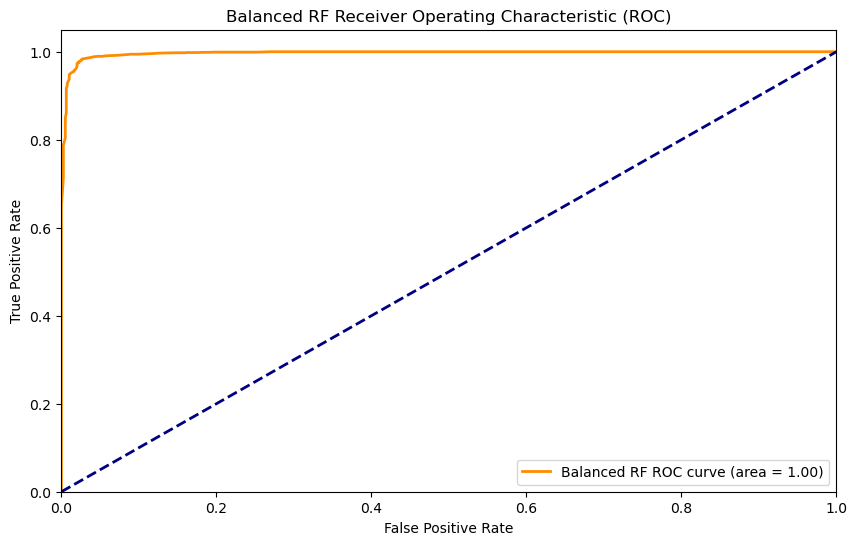

In [34]:
# Define the scaler
scaler = StandardScaler()

# Balanced Random Forest Classifier
rf_model = RandomForestClassifier(class_weight='balanced', n_jobs=-1)

# Grid parameters for RandomForest
rf_grid_params = {
    'model__n_estimators': [100, 200], # Number of trees in the forest
    'model__max_features': ['auto', 'sqrt', 'log2'], # Number of features to consider at every split
    'model__max_depth': [None, 10, 20], # Maximum number of levels in tree
    'model__min_samples_split': [2, 5] # Minimum number of samples required to split a node
}

# Pipeline for Balanced Random Forest
rf_pipeline = Pipeline([
    ('scaler', scaler),
    ('model', rf_model)
])

# Grid search for Balanced Random Forest
rf_grid_search = GridSearchCV(rf_pipeline, rf_grid_params, cv=5, scoring='f1', n_jobs=-1)

# Fit the Random Forest grid search
rf_grid_search.fit(X_train, y_train)

# Get the best parameters and model for RF
rf_best_params = rf_grid_search.best_params_
print("Balanced RF Best parameters:", rf_best_params)

rf_best_score = rf_grid_search.best_score_
print("Balanced RF Best score:", rf_best_score)

rf_best_model = rf_grid_search.best_estimator_

# Predict and evaluate RF
y_pred_rf = rf_best_model.predict(X_test)
f1_rf = f1_score(y_test, y_pred_rf)
print("Balanced RF F1 score:", f1_rf)

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Balanced RF Confusion Matrix')
plt.show()

class_report_rf = classification_report(y_test, y_pred_rf)
print("Balanced RF Classification Report:\n", class_report_rf)

if len(np.unique(y_test)) == 2:
    y_prob_rf = rf_best_model.predict_proba(X_test)[:, 1]
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
    roc_auc_rf = auc(fpr_rf, tpr_rf)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='Balanced RF ROC curve (area = %0.2f)' % roc_auc_rf)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Balanced RF Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()
else:
    print("ROC curve is only applicable for binary classification in Balanced RF.")



# XGBoost Grid Search with scale_pos_weight Parameter

Best parameters: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.2, 'xgb__max_depth': 5, 'xgb__n_estimators': 300, 'xgb__scale_pos_weight': 1, 'xgb__subsample': 1}
Average F1 Score from Nested Cross-Validation: 0.9853696752046641
F1 score: 0.993862134088763


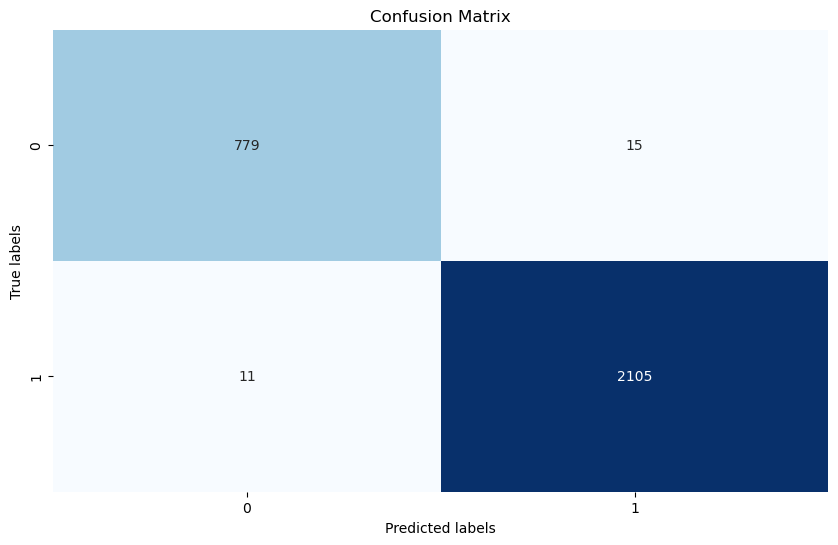

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       794
           1       0.99      0.99      0.99      2116

    accuracy                           0.99      2910
   macro avg       0.99      0.99      0.99      2910
weighted avg       0.99      0.99      0.99      2910



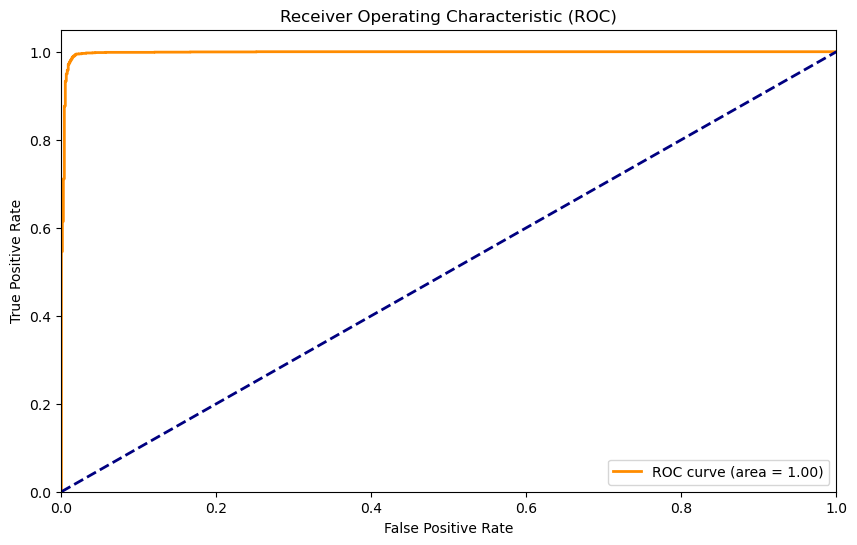

In [14]:
# Define the XGBoost model with initial parameters
xgb = XGBClassifier()

# Define the grid search parameters for XGBoost
grid_params = {
    'xgb__n_estimators': [100, 200, 300],  # Number of trees in the forest
    'xgb__max_depth': [3, 4, 5],  # Maximum depth of the tree
    'xgb__learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'xgb__subsample': [0.8, 1],  # Subsample ratio of the training instances
    'xgb__colsample_bytree': [0.8, 1],  # Subsample ratio of columns when constructing each tree
    'xgb__scale_pos_weight': [1, 10, 50]  # Scale weight for positive class (class balancing)
}

# Define a pipeline that includes scaling and XGBoost
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale the data
    ('xgb', xgb)  # Apply XGBoost
])

# Define the inner cross-validation
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the outer cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the grid search with nested cross-validation
nested_grid_search = GridSearchCV(pipeline, grid_params, cv=inner_cv, scoring='f1', n_jobs=-1)

# Perform nested cross-validation
nested_scores = []
for train_index, test_index in outer_cv.split(X_train):
    X_train_inner, X_test_inner = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_inner, y_test_inner = y_train.iloc[train_index], y_train.iloc[test_index]

    # Fit grid search on the inner cross-validation set
    nested_grid_search.fit(X_train_inner, y_train_inner)
    
    # Get the best model from the inner grid search
    best_model = nested_grid_search.best_estimator_
    
    # Evaluate the model on the outer test set
    y_pred = best_model.predict(X_test_inner)
    
    # Calculate the F1 score
    f1 = f1_score(y_test_inner, y_pred)
    nested_scores.append(f1)

# Print the best hyperparameters
best_params = nested_grid_search.best_params_
print("Best parameters:", best_params)

# Print the average F1 score from the nested cross-validation
print(f'Average F1 Score from Nested Cross-Validation: {np.mean(nested_scores)}')

# Train the final model on the entire dataset
final_model = nested_grid_search.best_estimator_
final_model.fit(X_train, y_train)

# Predict on the test set
y_pred = final_model.predict(X_test)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)
print("F1 score:", f1)

# Define the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Define the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Define the ROC curve
if len(np.unique(y_test)) == 2:  # Ensure binary classification
    y_prob = final_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    # Calculate the AUC score
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()
else:
    print("ROC curve is only applicable for binary classification.")


# XGBoost with Oversampling

c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:16:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:20:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:24:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not u

Best parameters: {'xgb__colsample_bytree': 1, 'xgb__learning_rate': 0.2, 'xgb__max_depth': 5, 'xgb__n_estimators': 300, 'xgb__subsample': 1}
Average F1 Score from Nested Cross-Validation: 0.9855


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:32:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


F1 score: 0.9910080454330336


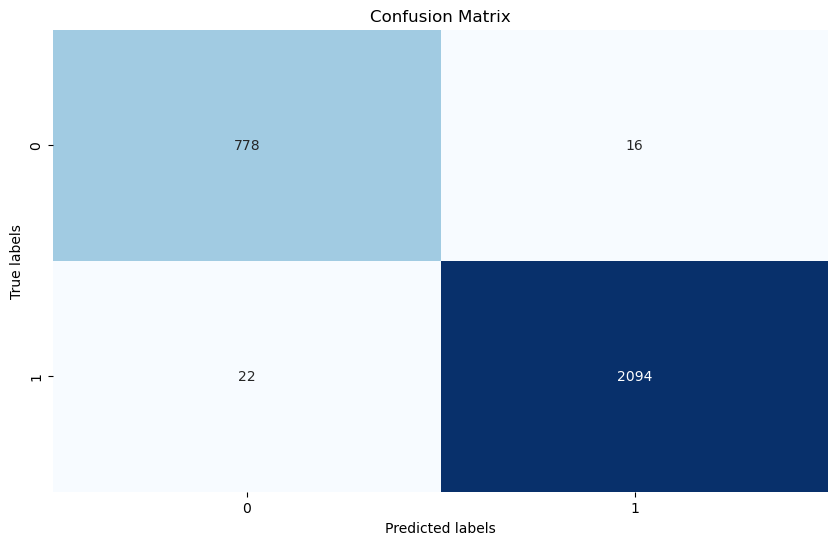

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       794
           1       0.99      0.99      0.99      2116

    accuracy                           0.99      2910
   macro avg       0.98      0.98      0.98      2910
weighted avg       0.99      0.99      0.99      2910



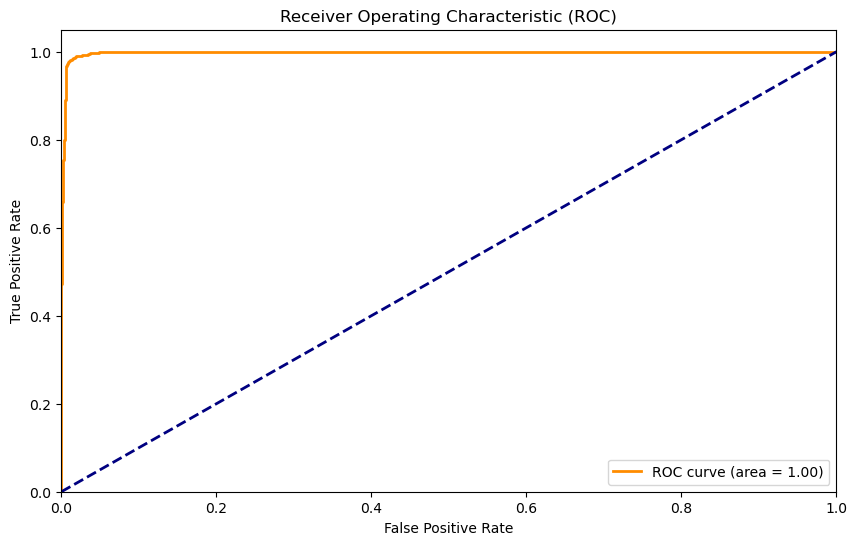

In [36]:
# Define the XGBoost model with initial parameters
xgb = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42) # Use multi-class log loss as the evaluation metric to handle multi-class classification

# Define the grid search parameters for XGBoost
grid_params = {
    'xgb__n_estimators': [100, 200, 300], # Number of trees in the forest
    'xgb__max_depth': [3, 4, 5], # Maximum depth of the tree
    'xgb__learning_rate': [0.01, 0.1, 0.2], # Learning rate
    'xgb__subsample': [0.8, 1], # Subsample ratio of the training instances
    'xgb__colsample_bytree': [0.8, 1] # Subsample ratio of columns when constructing each tree
}

# Define the resampling method
resampler = RandomOverSampler(sampling_strategy='not majority', random_state=42)

# Pipeline that includes StandardScaler, RandomOverSampler, and XGBoost
pipeline = Pipeline([
    ('scaler', StandardScaler()),   # Scale the data
    ('resampler', resampler),       # Apply Random Oversampling
    ('xgb', xgb)                    # Apply XGBoost
])

# Define the inner cross-validation
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42) # Use 5-fold cross-validation with shuffling and set the random state to 42 for reproducibility

# Define the outer cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42) 

# Define the grid search with nested cross-validation
nested_grid_search = GridSearchCV(pipeline, grid_params, cv=inner_cv, scoring='f1', n_jobs=-1)

# Perform nested cross-validation
nested_scores = []
for train_index, test_index in outer_cv.split(X_train):
    X_train_inner, X_test_inner = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_inner, y_test_inner = y_train.iloc[train_index], y_train.iloc[test_index]

    # Fit grid search on the inner cross-validation set
    nested_grid_search.fit(X_train_inner, y_train_inner)
    
    # Get the best model from the inner grid search
    best_model = nested_grid_search.best_estimator_
    
    # Evaluate the model on the outer test set
    y_pred = best_model.predict(X_test_inner)
    
    # Calculate the F1 score
    f1 = f1_score(y_test_inner, y_pred)
    nested_scores.append(f1)

# Print the best hyperparameters
best_params = nested_grid_search.best_params_
print("Best parameters:", best_params)

# Print the average F1 score from the nested cross-validation
print(f'Average F1 Score from Nested Cross-Validation: {np.mean(nested_scores):.4f}')

# Train the final model on the entire dataset
final_model = nested_grid_search.best_estimator_
final_model.fit(X_train, y_train)

# Predict on the test set
y_pred = final_model.predict(X_test)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)
print("F1 score:", f1)

# Define the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Define the classification report
class_report = classification_report(y_test, y_pred)
print(class_report)

# Define the ROC curve
fpr, tpr, _ = roc_curve(y_test, final_model.predict_proba(X_test)[:, 1])

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()




# XGBoost with no resampling strategy

Best parameters: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.2, 'xgb__max_depth': 5, 'xgb__n_estimators': 300, 'xgb__subsample': 1}
Average F1 Score from Nested Cross-Validation: 0.9853696752046641
F1 score: 0.993862134088763


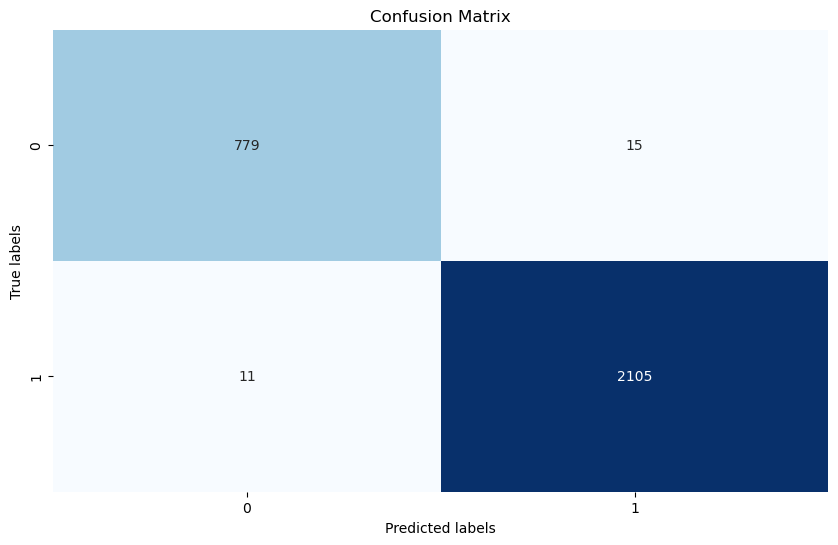

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       794
           1       0.99      0.99      0.99      2116

    accuracy                           0.99      2910
   macro avg       0.99      0.99      0.99      2910
weighted avg       0.99      0.99      0.99      2910



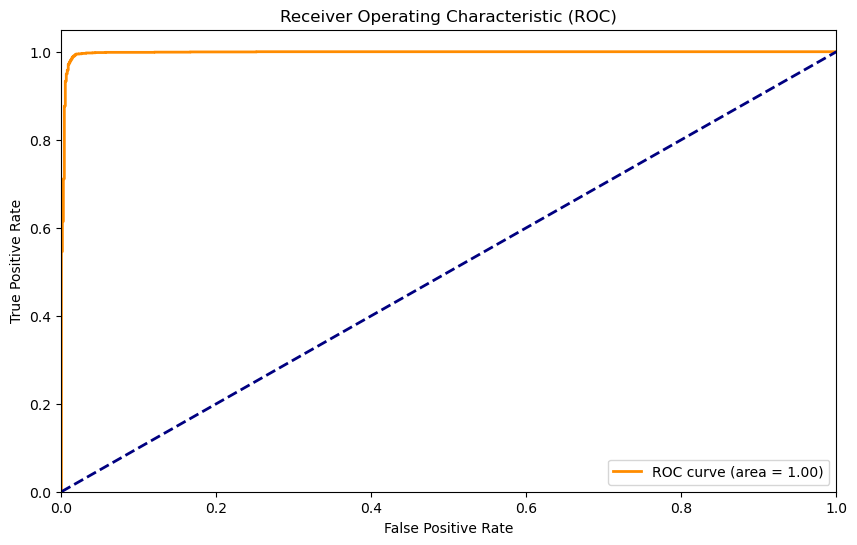

In [77]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

# Define the XGBoost model with initial parameters
xgb = XGBClassifier() 

# Define the grid search parameters for XGBoost
grid_params = {
    'xgb__n_estimators': [100, 200, 300], # Number of trees in the forest
    'xgb__max_depth': [3, 4, 5], # Maximum depth of the tree
    'xgb__learning_rate': [0.01, 0.1, 0.2], # Learning rate
    'xgb__subsample': [0.8, 1], # Subsample ratio of the training instances
    'xgb__colsample_bytree': [0.8, 1] # Subsample ratio of columns when constructing each tree
}

# pipeline that includes StandardScaler and XGBoost
pipeline = Pipeline([
    ('scaler', StandardScaler()),   # Scale the data
    ('xgb', xgb)                    # Apply XGBoost
])

# Define the inner cross-validation
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42) # Use 5-fold cross-validation with shuffling and set the random state to 42 for reproducibility

# Define the outer cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42) 

# Define the grid search with nested cross-validation
nested_grid_search = GridSearchCV(pipeline, grid_params, cv=inner_cv, scoring='f1', n_jobs=-1)

# Perform nested cross-validation
nested_scores = []
for train_index, test_index in outer_cv.split(X_train):
    X_train_inner, X_test_inner = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_inner, y_test_inner = y_train.iloc[train_index], y_train.iloc[test_index]

    # Fit grid search on the inner cross-validation set
    nested_grid_search.fit(X_train_inner, y_train_inner)
    
    # Get the best model from the inner grid search
    best_model = nested_grid_search.best_estimator_
    
    # Evaluate the model on the outer test set
    y_pred = best_model.predict(X_test_inner)
    
    # Calculate the F1 score
    f1 = f1_score(y_test_inner, y_pred)
    nested_scores.append(f1)

# print the best hyper parameters
best_params = nested_grid_search.best_params_
print("Best parameters:", best_params)

# Print the average F1 score from the nested cross-validation
print(f'Average F1 Score from Nested Cross-Validation: {np.mean(nested_scores)}')

# Train the final model on the entire dataset
final_model = nested_grid_search.best_estimator_
final_model.fit(X_train, y_train)

# Predict on the test set
y_pred = final_model.predict(X_test)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)
print("F1 score:", f1)

# Define the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Define the classification report
class_report = classification_report(y_test, y_pred)
print(class_report)

# Define the ROC curve
fpr, tpr, _ = roc_curve(y_test, final_model.predict_proba(X_test)[:, 1])

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


In [14]:
# Define the results
best_params = {
    'xgb__colsample_bytree': 0.8, # Subsample ratio of columns when constructing each tree
    'xgb__learning_rate': 0.2, # Learning rate
    'xgb__max_depth': 5, # Maximum depth of the tree
    'xgb__n_estimators': 300, # Number of trees in the forest
    'xgb__scale_pos_weight': 1, # Scale weight for positive class. 1 is the default value. 
    'xgb__subsample': 1 # Subsample ratio of the training instances
}

# Print the summary
print("The best performing models are the XGBoost models with and without scale_pos_weight. Both have the following hyperparameters:")
print(f"Best parameters: {best_params}")
print(f"Average F1 Score from Nested Cross-Validation: {average_f1_score:.5f}")
print(f"F1 score on the test set: {f1_score:.5f}")


# Application of XGBoost on differently processed data

just standard scaled data

c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:57:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


F1 score: 0.993862134088763


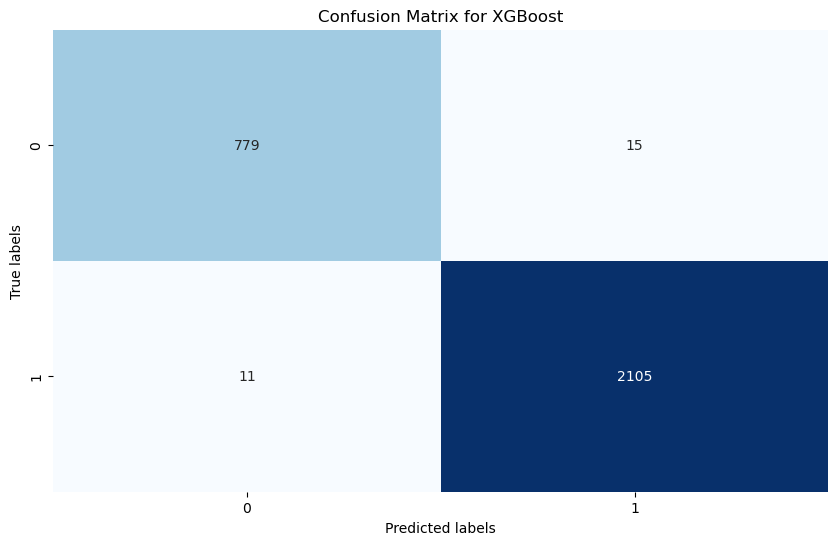

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       794
           1       0.99      0.99      0.99      2116

    accuracy                           0.99      2910
   macro avg       0.99      0.99      0.99      2910
weighted avg       0.99      0.99      0.99      2910



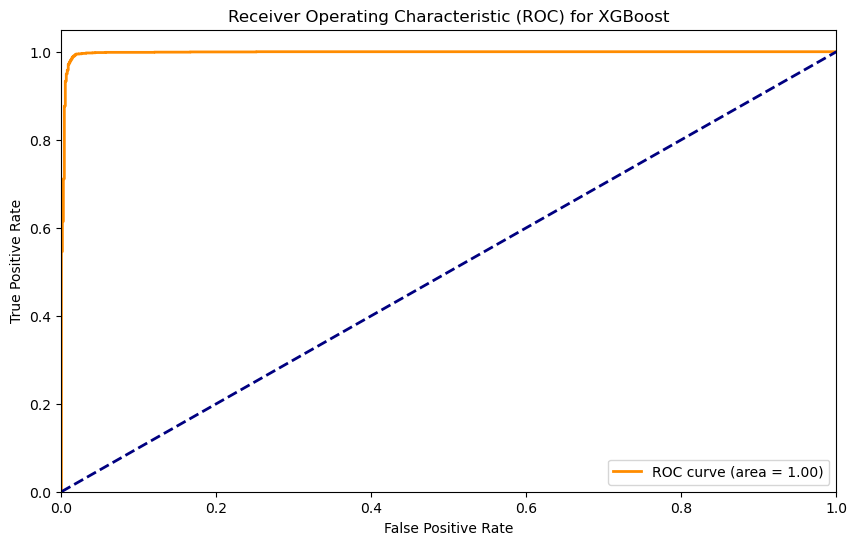

In [15]:
# Initialize StandardScaler
scaler = StandardScaler()

# Scale the training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize XGBoost with the best parameters
xgb = XGBClassifier(
    colsample_bytree=best_params['xgb__colsample_bytree'],
    learning_rate=best_params['xgb__learning_rate'],
    max_depth=best_params['xgb__max_depth'],
    n_estimators=best_params['xgb__n_estimators'],
    scale_pos_weight=best_params['xgb__scale_pos_weight'],
    subsample=best_params['xgb__subsample'],
    eval_metric='mlogloss', # Use multi-class log loss as the evaluation metric
    use_label_encoder=False
)

# Fit the XGBoost model
xgb.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = xgb.predict(X_test_scaled)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)
print("F1 score:", f1)


# Define and plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for XGBoost')
plt.show()


# Define and print the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Define and plot the ROC curve
if len(set(y_test)) == 2:  # Ensure binary classification
    y_prob = xgb.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) for XGBoost')
    plt.legend(loc='lower right')
    plt.show()
else:
    print("ROC curve is only applicable for binary classification.")


# XGBoost on raw data

c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:03:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


F1 score: 0.993862134088763


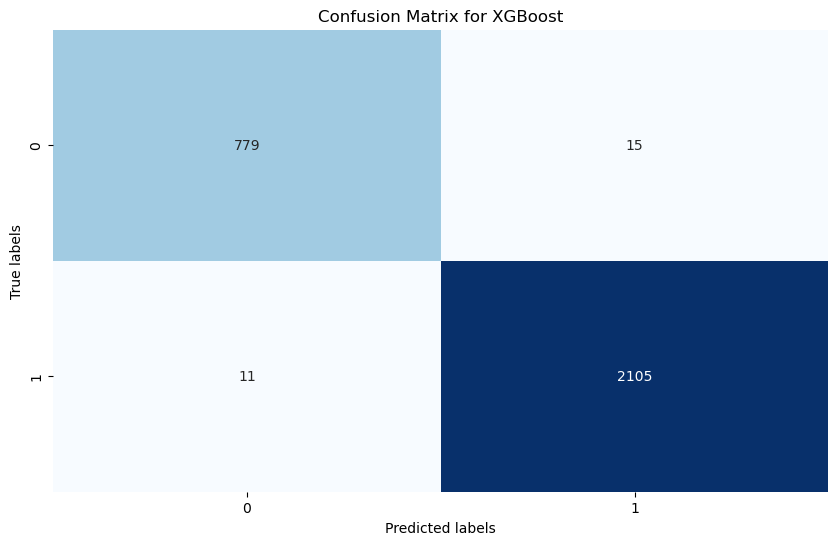

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       794
           1       0.99      0.99      0.99      2116

    accuracy                           0.99      2910
   macro avg       0.99      0.99      0.99      2910
weighted avg       0.99      0.99      0.99      2910



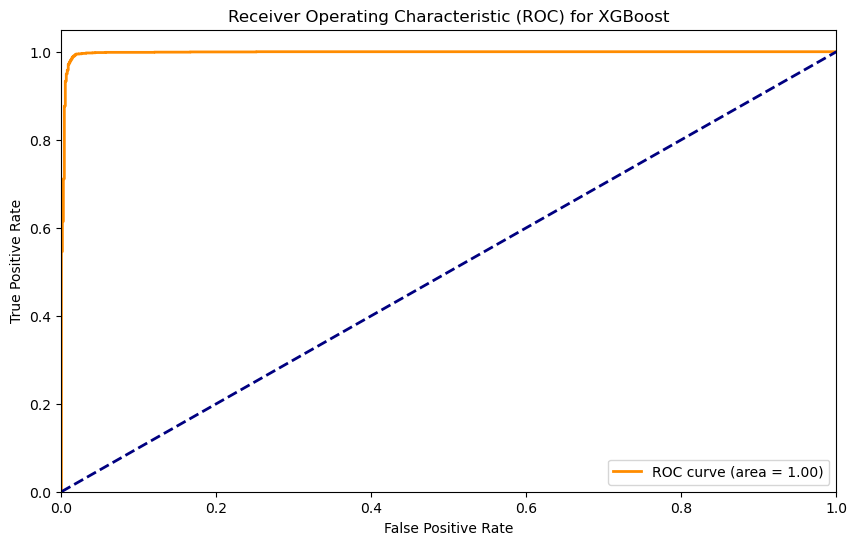

In [19]:
# Initialize XGBoost with the best parameters
xgb = XGBClassifier(
    colsample_bytree=best_params['xgb__colsample_bytree'],
    learning_rate=best_params['xgb__learning_rate'],
    max_depth=best_params['xgb__max_depth'],
    n_estimators=best_params['xgb__n_estimators'],
    scale_pos_weight=best_params['xgb__scale_pos_weight'],
    subsample=best_params['xgb__subsample'],
    eval_metric='mlogloss',  # Use multi-class log loss as the evaluation metric
    use_label_encoder=False
)

# Fit the XGBoost model on the raw, unscaled data
xgb.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb.predict(X_test)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)
print("F1 score:", f1)

# Define and plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for XGBoost')
plt.show()

# Define and print the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Define and plot the ROC curve
if len(set(y_test)) == 2:  # Ensure binary classification
    y_prob = xgb.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) for XGBoost')
    plt.legend(loc='lower right')
    plt.show()
else:
    print("ROC curve is only applicable for binary classification.")

# XGBoost on PCA 

c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:01:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


F1 score: 0.9712941176470589


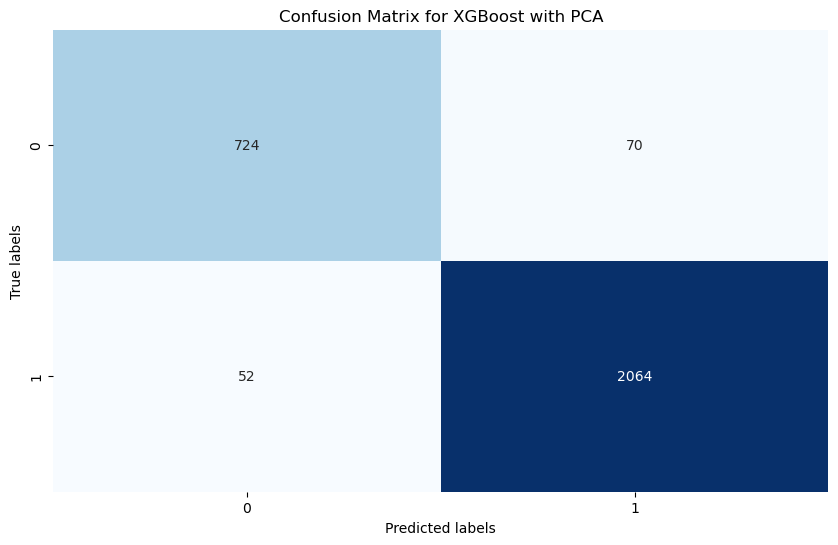

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       794
           1       0.97      0.98      0.97      2116

    accuracy                           0.96      2910
   macro avg       0.95      0.94      0.95      2910
weighted avg       0.96      0.96      0.96      2910



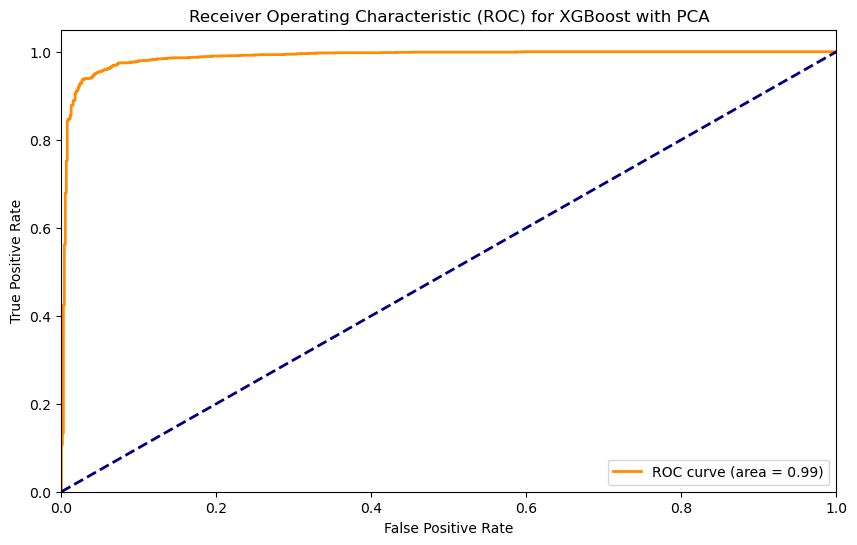

In [18]:
# Initialize PCA with the number of components to retain
pca = PCA(n_components=0.95)

# Initialize XGBoost with the best parameters
xgb = XGBClassifier(
    colsample_bytree=best_params['xgb__colsample_bytree'],
    learning_rate=best_params['xgb__learning_rate'],
    max_depth=best_params['xgb__max_depth'],
    n_estimators=best_params['xgb__n_estimators'],
    scale_pos_weight=best_params['xgb__scale_pos_weight'],
    subsample=best_params['xgb__subsample'],
    eval_metric='mlogloss',  # Use multi-class log loss as the evaluation metric
    use_label_encoder=False
)

# Create a pipeline with PCA and XGBoost
pipeline = Pipeline([
    ('pca', pca),
    ('xgb', xgb)
])
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)
print("F1 score:", f1)

# Define and plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for XGBoost with PCA')
plt.show()

# Define and print the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Define and plot the ROC curve
if len(set(y_test)) == 2:  # Ensure binary classification
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) for XGBoost with PCA')
    plt.legend(loc='lower right')
    plt.show()
else:
    print("ROC curve is only applicable for binary classification.")

In [22]:
print("XGBoost performs best with Standard Scaler or without scaling. PCA does not improve the performance of the model. Accounting for unbalanced classes with scale_pos_weight or oversampling also does not improve the performance of the model. However, the model performance is already pretty accurate.")


XGBoost performs best with Standard Scaler or without scaling. PCA does not improve the performance of the model. Accounting for unbalanced classes with scale_pos_weight or oversampling also does not improve the performance of the model. However, the model performance is already pretty accurate.
